# Stokes Flow

Test based on [CHiMaD Phase Field Benchmark Problem 5b](https://pages.nist.gov/pfhub/benchmarks/benchmark5-hackathon.ipynb)

## Import Python modules

In [64]:
import argparse
from textwrap import dedent
# import json
# import os
# import re
# import sys
import time
import json
import fipy as fp
try:
    import pathlib
except ImportError:
    import pathlib2 as pathlib

## Initialize
### Load parameters

In [65]:
parser = argparse.ArgumentParser()
parser.add_argument("--solver", help="solver class to use", default="pcg")
parser.add_argument("--preconditioner", help="preconditioner class to use", default="none")
parser.add_argument("--sweeps", help="number of nonlinear sweeps to take",
                    type=int, default=5)

parser.add_argument("--gx", help="x-component of gravity",
                    type=float, default=0.0)
parser.add_argument("--gy", help="y-component of gravity",
                    type=float, default=-0.001)

parser.add_argument("--Lx", help="simulation size in x dimension",
                    type=float, default=30.0)
parser.add_argument("--Ly", help="simulation size in y dimension",
                    type=float, default=6.0)
parser.add_argument("--nx", help="number of grid cells in x dimension",
                    type=float, default=1024)
parser.add_argument("--totaltime", help="IGNORED",
                    type=float, default=1.0)

parser.add_argument("--iterations", help="maximum number of linear iterations to take for each sweep",
                    type=int, default=1000)
parser.add_argument("--tolerance", help="linear solver tolerance",
                    default=1e-10)
parser.add_argument("--profile",
                    help="store profiling statistics along with other output",
                    action='store_true')
parser.add_argument("--view",
                    help="whether to view the results",
                    action='store_true')

_StoreTrueAction(option_strings=['--view'], dest='view', nargs=0, const=True, default=False, type=None, choices=None, required=False, help='whether to view the results', metavar=None)

In [48]:
args, unknowns = parser.parse_known_args(args=None)

In [49]:
import fipy as fp

viscosity = 1
density = 100.
gravity = [args.gx, args.gy]
pressureRelaxation = 0.8
velocityRelaxation = 0.5

cellSize = args.Lx / args.nx

In [50]:
mesh = fp.Gmsh2D(dedent(f'''
    Lx = {args.Lx};
    Ly = {args.Ly};
    cellSize = {cellSize};
                     
    Point(1) = {{0, 0, 0, cellSize}};
    Point(2) = {{{args.Lx}, 0, 0, cellSize}};
    Point(3) = {{{args.Lx}, {args.Ly}, 0, cellSize}};
    Point(4) = {{0, 6, 0, cellSize}};
    Point(5) = {{7, 2.5, 0, cellSize}};
    Point(6) = {{7, 4, 0, cellSize}};
    Point(7) = {{6, 2.5, 0, cellSize}};
    Point(8) = {{7, 1, 0, cellSize}};
    Point(9) = {{8, 2.5, 0, cellSize}};
                     
    Line(1) = {{1, 2}};
    Line(2) = {{2, 3}};
    Line(3) = {{3, 4}};
    Line(4) = {{4, 1}};
    Ellipse(5) = {{7, 5, 6, 6}};
    Ellipse(6) = {{6, 5, 9, 9}};
    Ellipse(7) = {{9, 5, 8, 8}};
    Ellipse(8) = {{8, 5, 7, 7}};

    Line Loop(9) = {{1, 2, 3, 4}};
    Line Loop(10) = {{5, 6, 7, 8}};
    Plane Surface(11) = {{9, 10}};

    Physical Surface("cells") = {{11}};
                     
    Physical Line("bottom") = {{1}};
    Physical Line("right") = {{2}};
    Physical Line("top") = {{3}};
    Physical Line("left") = {{4}};
    Physical Line("hole") = {{5, 6, 7, 8}};
'''))

X, Y = mesh.faceCenters

inlet = mesh.physicalFaces["left"]
outlet = mesh.physicalFaces["right"]
walls = mesh.physicalFaces["top"] | mesh.physicalFaces["bottom"] | mesh.physicalFaces["hole"]
top_right = outlet & (Y > max(Y) - cellSize)

In [ ]:
volumes = fp.CellVariable(mesh=mesh, value=mesh.cellVolumes)

pressure = fp.CellVariable(mesh=mesh, name="$p$")
pressureCorrection = fp.CellVariable(mesh=mesh, name="$p'$")
xVelocity = fp.CellVariable(mesh=mesh, name="$u_x$")
yVelocity = fp.CellVariable(mesh=mesh, name="$u_y$")

velocity = fp.FaceVariable(mesh=mesh, name=r"$\vec{u}$", rank=1)

xVelocityEq = fp.DiffusionTerm(coeff=viscosity) - pressure.grad.dot([[1.],[0.]]) + density * gravity[0]
yVelocityEq = fp.DiffusionTerm(coeff=viscosity) - pressure.grad.dot([[0.],[1.]]) + density * gravity[1]

ap = fp.CellVariable(mesh=mesh, value=1.)
coeff = 1./ ap.arithmeticFaceValue*mesh._faceAreas * mesh._cellDistances

x, y = mesh.cellCenters
top_right_cell = fp.CellVariable(mesh=mesh, value=(x > max(x) - cellSize) & (y > max(y) - cellSize))

large_value = 1e10
pressureCorrectionEq = (fp.DiffusionTerm(coeff=coeff) - velocity.divergence 
                        - fp.ImplicitSourceTerm(coeff=top_right_cell * large_value) 
                        + top_right_cell * large_value * 0.)

contrvolume = volumes.arithmeticFaceValue

def inlet_velocity(yy):
    return -0.001 * (yy - 3)**2 + 0.009

X, Y = mesh.faceCenters

xVelocity.constrain(inlet_velocity(Y), inlet)
xVelocity.constrain(0., walls)
xVelocity.faceGrad.constrain(0., outlet)

yVelocity.constrain(0., walls | inlet)
yVelocity.faceGrad.constrain(0., outlet)

pressure.faceGrad.constrain([[density * gravity[0]], [0.]], outlet)
pressureCorrection.faceGrad.constrain([[0.], [0.]], outlet)

## Create solver

In [ ]:
precon = None

if args.preconditioner == "jacobi":
    precon = fp.JacobiPreconditioner()
elif args.preconditioner == "ilu":
    precon = fp.ILUPreconditioner()
elif args.preconditioner == "ssor":
    precon = fp.SSORPreconditioner()
elif args.preconditioner == "icc":
    precon = fp.ICPreconditioner()
elif args.preconditioner == "none":
    precon = None
else:
    precon = fp.solvers.__dict__[args.preconditioner]()

if args.solver == "cgs":
    solver_class = fp.LinearCGSSolver
elif args.solver == "gmres":
    solver_class = fp.LinearGMRESSolver
elif args.solver == "lu":
    solver_class = fp.LinearLUSolver
elif args.solver == "pcg":
    solver_class = fp.LinearPCGSolver
else:
    solver_class = fp.solvers.__dict__[args.solver]

In [ ]:
if solver_class == fp.LinearLUSolver:
    precon = None # preconditioned lu doesn't make any sense

In [ ]:
solver = solver_class(tolerance=args.tolerance, criterion="RHS",
                      iterations=args.iterations, precon=precon)

### time simulation

In [66]:
start = time.time()

for sweep in range(1, args.sweeps+1):
    ## solve the Stokes equations to get starred values
    xVelocityEq.cacheMatrix()
    xres = xVelocityEq.sweep(var=xVelocity,
                             underRelaxation=velocityRelaxation,
                             solver=solver)
    xmat = xVelocityEq.matrix

    yres = yVelocityEq.sweep(var=yVelocity,
                             underRelaxation=velocityRelaxation,
                             solver=solver)

    ## update the ap coefficient from the matrix diagonal
    ap[:] = -xmat.takeDiagonal()

    ## update the face velocities based on starred values with the
    ## Rhie-Chow correction.
    ## cell pressure gradient
    presgrad = pressure.grad
    ## face pressure gradient
    facepresgrad = pressure.faceGrad

    velocity[0] = xVelocity.arithmeticFaceValue \
         + contrvolume / ap.arithmeticFaceValue * \
           (presgrad[0].arithmeticFaceValue-facepresgrad[0])
    velocity[1] = yVelocity.arithmeticFaceValue \
         + contrvolume / ap.arithmeticFaceValue * \
           (presgrad[1].arithmeticFaceValue-facepresgrad[1])
    velocity[..., mesh.exteriorFaces.value] = 0.
    velocity[0, inlet.value] = inlet_velocity(Y)[inlet.value]
    velocity[0, outlet.value] = xVelocity.faceValue[outlet.value]
    velocity[1, outlet.value] = yVelocity.faceValue[outlet.value]

    ## solve the pressure correction equation
    pressureCorrectionEq.cacheRHSvector()
    ## right top point must remain at pressure 0, so no correction
    pres = pressureCorrectionEq.sweep(var=pressureCorrection, solver=solver)
    rhs = pressureCorrectionEq.RHSvector

    ## update the pressure using the corrected value
    pressure.setValue(pressure + pressureRelaxation * pressureCorrection)
    ## update the velocity using the corrected pressure
    xVelocity.setValue(xVelocity - pressureCorrection.grad[0] / \
                                               ap * mesh.cellVolumes)
    yVelocity.setValue(yVelocity - pressureCorrection.grad[1] / \
                                               ap * mesh.cellVolumes)

end = time.time()

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_70827/1367268092.py:37: DivergenceWarning: msg=KSP_DIVERGED_ITS, code=-3, residual=0.00010427583913953179
  pres = pressureCorrectionEq.sweep(var=pressureCorrection)
/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_70827/1367268092.py:37: DivergenceWarning: msg=KSP_DIVERGED_ITS, code=-3, residual=0.00010896117294934743
  pres = pressureCorrectionEq.sweep(var=pressureCorrection)
/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_70827/1367268092.py:37: DivergenceWarning: msg=KSP_DIVERGED_ITS, code=-3, residual=0.000282027588681887
  pres = pressureCorrectionEq.sweep(var=pressureCorrection)
/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_70827/1367268092.py:37: DivergenceWarning: msg=KSP_DIVERGED_ITS, code=-3, residual=0.0004205511858989576
  pres = pressureCorrectionEq.sweep(var=pressureCorrection)
/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_70827/1367268092.py:37: DivergenceWarning: m

In [ ]:
if args.view:
    fp.Viewer(vars=xVelocity)

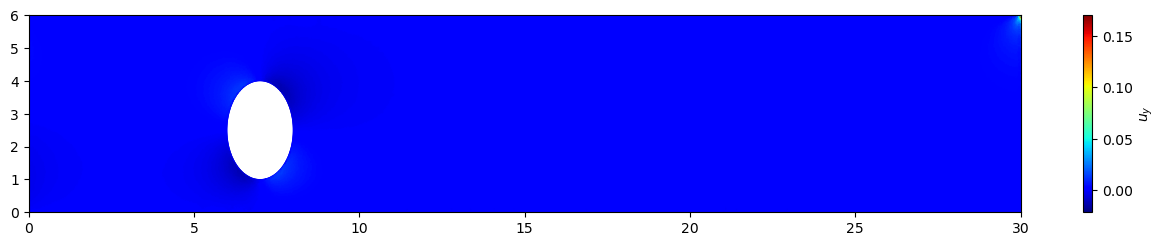

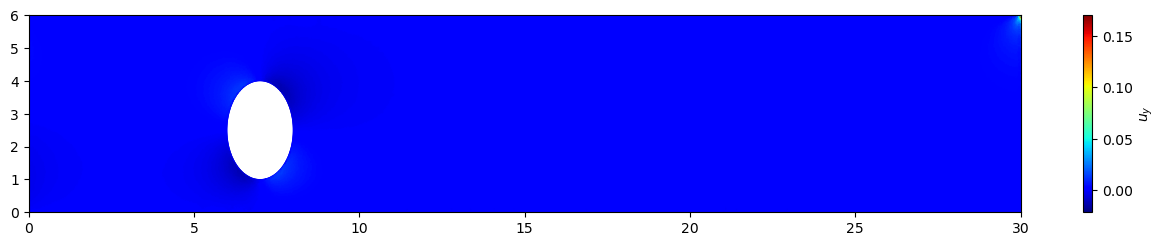

In [62]:
if args.view:
    fp.Viewer(vars=yVelocity)

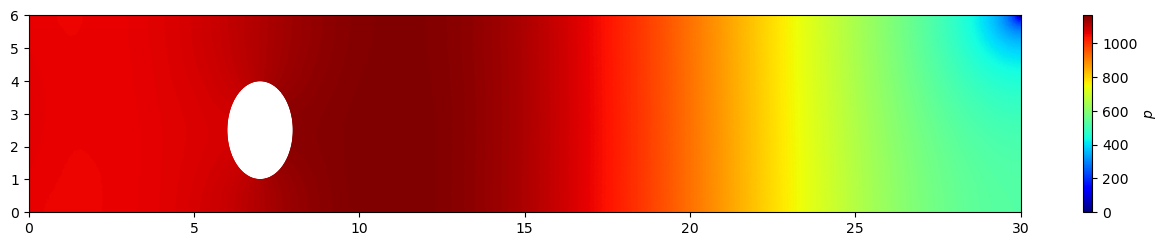

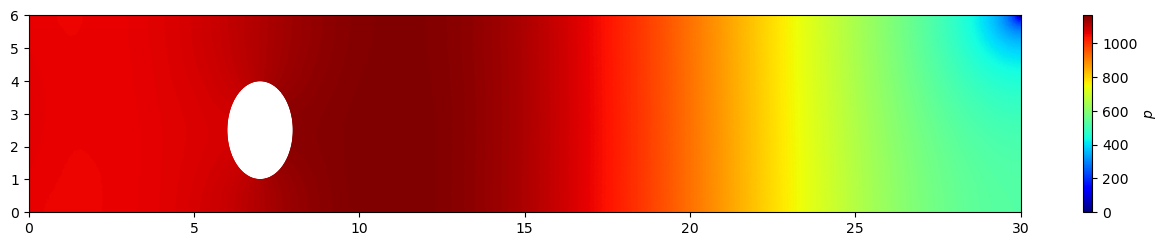

In [63]:
if args.view:
    fp.Viewer(vars=pressure)

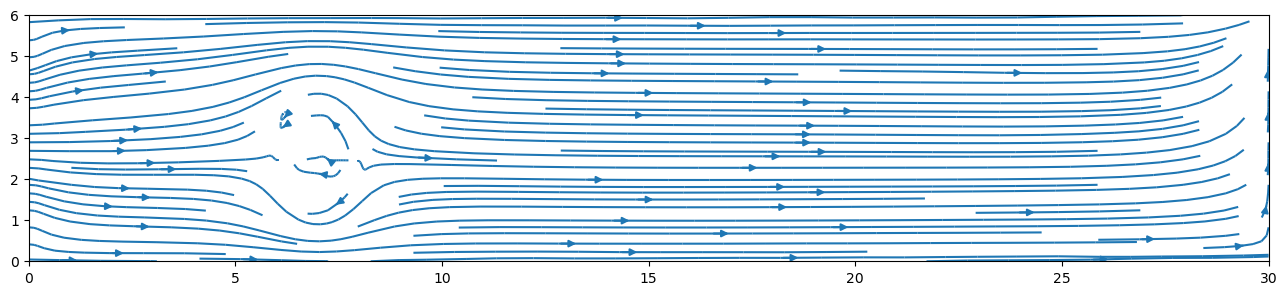

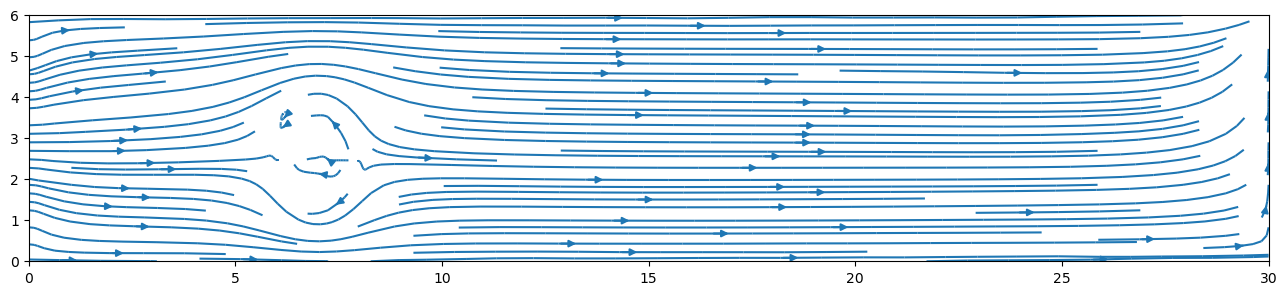

In [55]:
if args.view:
    fp.MatplotlibStreamViewer(vars=velocity)

In [71]:
results = {
    "elapsed / s": end - start,
    "ncells": mesh.globalNumberOfCells
}

if fp.parallel.procID == 0:
    print(json.dumps(results))

{"elapsed / s": 63.27791476249695, "ncells": 473462}
